<a href="https://colab.research.google.com/github/MasiboBrian/AirBNB-Price-Prediction/blob/master/CycleGans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cycle GAN in PyTorch

In [ ]:
%load_ext autoreload
%matplotlib inline
!pip install utils

In [ ]:
!pip install python_utils
from python_utils import Logged

ImportError: ignored

In [ ]:
%autoreload 2

from IPython import display

import torch

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
DATA_FOLDER = './torch_data/CycleGAN'

In [ ]:
import os
import urllib, zipfile
from tqdm import tqdm
import zipfile

VALID_DATA_NAMES = ["ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes","facades","iphone2dslr_flower","mini", "mini_pix2pix", "mini_colorization"]

URL = 'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{}.zip'
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def rename_images(rootdir):
    for subdir, dirs, files in os.walk(rootdir):
        idx = 0
        for file in files:
            file_path = os.path.join(subdir, file)
            new_file_path = os.path.join(subdir, "{}.jpg".format(idx))
            os.rename(file_path, new_file_path)
            idx = idx + 1

def download_cyclegan_dataset(filename, path, force=False):
    # Validate dataset filename is valid.
    assert(filename in VALID_DATA_NAMES)
    # Return if path exists.
    file_path = "{}/{}.zip".format(path, filename)
    if(os.path.exists(file_path) and not force): return
    # Otherwise download.

    # Make path directory if missing.
    os.makedirs(path, exist_ok=True)
    # Download data
    url = URL.format(filename)
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, file_path, reporthook=t.update_to)
        with zipfile.ZipFile(file_path, 'r') as zip_obj:
            zip_obj.extractall(path)
    rename_images(os.path.join(path, filename))

In [ ]:
for name in VALID_DATA_NAMES:
    download_cyclegan_dataset(name, DATA_FOLDER, force=False)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from skimage import io

class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, path, transform=None):
        self._path = path
        self.num_files = len(os.listdir(self._path))
        self.transform = transform

    def __len__(self):
        return self.num_files

    def filename(self, idx):
        for directory in ["trainA", "testA"]:
            possible_path = os.path.join(self._path, directory, "{}.jpg".format(str(idx)))
            if os.path.exists(possible_path):
                return possible_path

    def __getitem__(self, idx):
        # Handle vectors.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.filename(idx)
        print(img_name)
        image = Image.fromarray(io.imread(img_name))
        if self.transform:
            image = self.transform(image)
        return image

    def visualize(self, idx):
        np_img = np.transpose(self[idx].numpy(), (1,2, 0))
        plt.imshow(np_img)

### Load Data

In [ ]:
def my_data():
    compose = transforms.Compose(
        [transforms.Resize((80, 80)),
         transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    return MyDataset(DATA_FOLDER + "/ae_photos", transform=compose)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./torch_data/CycleGAN/ae_photos/testA/101.jpg


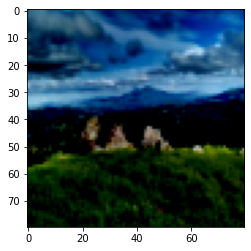

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data = MyDataset(DATA_FOLDER + "/ae_photos")
data = my_data()
# Create loader with data, so that we can iterate over it.
# data_loader = torch.utils.data.DataLoader(my_data(), batch_size=10, shuffle=True)
# plt.imshow(np.flip(my_data()[48], 1))
# plt.imshow(my_data()[48][1])
data.visualize(101)

#### Discriminator

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiscriminatorNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                                   kernel_size=(4, 4), stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                                   kernel_size=(4, 4), stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_out = nn.Conv2d(in_channels=512, out_channels=1,
                             kernel_size=(4, 4), stride=2)

    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_out(x)

In [ ]:
d = DiscriminatorNet()

#### Generator net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneratorNet(torch.nn.Module):

    def __init__(self):
        super(GeneratorNet, self).__init__()

        # c7s1-64
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=1,
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # d128
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2,
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # d256
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2,
                     padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # R256
        self.res_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # R256
        self.res_8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                               stride=2),
        # u128
        self.ups_9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=(3, 3), stride=0.5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # u64
        self.ups_10 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3),
                               stride=0.5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # c7s1-3
        self.conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7, 7), stride=1,
                      padding_mode='reflect'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    # TODO(diegoalejogm): Add skip layer connections.
    def forward(self, x):
        x = self.conv_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.res_3(x)
        x = self.res_4(x)
        x = self.res_5(x)
        x = self.res_6(x)
        x = self.res_7(x)
        x = self.res_8(x)
        x = self.ups_9(x)
        x = self.ups_10(x)
        x = self.conv_11(x)
        return x


In [ ]:
g = GeneratorNet()